In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings as wr
wr.filterwarnings(action="ignore")
wr.filterwarnings("ignore", category=UserWarning, module="matplotlib")
wr.filterwarnings("ignore", category=FutureWarning)
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from xgboost import XGBClassifier
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

In [ ]:
CARGA_MFLOW = False

<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Carga de datos</h1>
</div>

We are merging multiple datasets 

In [ ]:
account = pd.read_csv("data/Customer Profiles/account_activity.csv")
customer = pd.read_csv("data/Customer Profiles/customer_data.csv")
fraud = pd.read_csv("data/Fraudulent Patterns/fraud_indicators.csv")
suspision = pd.read_csv("data/Fraudulent Patterns/suspicious_activity.csv")
merchant = pd.read_csv("data/Merchant Information/merchant_data.csv")
tran_cat = pd.read_csv("data/Merchant Information/transaction_category_labels.csv")
amount = pd.read_csv("data/Transaction Amounts/amount_data.csv")
anamoly = pd.read_csv("data/Transaction Amounts/anomaly_scores.csv")
tran_data = pd.read_csv("data/Transaction Data/transaction_metadata.csv")
tran_rec = pd.read_csv("data/Transaction Data/transaction_records.csv")

data = [account,customer,fraud,suspision,merchant,tran_cat,amount,anamoly,tran_data,tran_rec]

for df in data:
    print(df.head())

   CustomerID  AccountBalance   LastLogin
0        1001     9507.272060  2022-01-01
1        1002     7408.704536  2022-01-02
2        1003     1715.321989  2022-01-03
3        1004     3101.509134  2022-01-04
4        1005     5405.766914  2022-01-05
   CustomerID           Name  Age       Address
0        1001  Customer 1001   54  Address 1001
1        1002  Customer 1002   35  Address 1002
2        1003  Customer 1003   40  Address 1003
3        1004  Customer 1004   30  Address 1004
4        1005  Customer 1005   46  Address 1005
   TransactionID  FraudIndicator
0              1               0
1              2               0
2              3               0
3              4               0
4              5               0
   CustomerID  SuspiciousFlag
0        1001               0
1        1002               0
2        1003               0
3        1004               0
4        1005               0
   MerchantID   MerchantName       Location
0        2001  Merchant 2001  Location

In [ ]:
costumer_data = pd.merge(customer, account, on='CustomerID')
costumer_data = pd.merge(costumer_data, suspision, on='CustomerID')
costumer_data

,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1001,Customer 1001,54,Address 1001,9507.272060,2022-01-01,0
1,1002,Customer 1002,35,Address 1002,7408.704536,2022-01-02,0
2,1003,Customer 1003,40,Address 1003,1715.321989,2022-01-03,0
3,1004,Customer 1004,30,Address 1004,3101.509134,2022-01-04,0
4,1005,Customer 1005,46,Address 1005,5405.766914,2022-01-05,0
...,...,...,...,...,...,...,...
995,1996,Customer 1996,33,Address 1996,8523.485163,2024-09-22,0
996,1997,Customer 1997,58,Address 1997,9255.451757,2024-09-23,0
997,1998,Customer 1998,25,Address 1998,9148.652759,2024-09-24,0
998,1999,Customer 1999,57,Address 1999,7376.854107,2024-09-25,0


In [ ]:
transaction_data1 = pd.merge(fraud, tran_cat, on="TransactionID")
transaction_data2 = pd.merge(amount, anamoly, on="TransactionID")
transaction_data3 = pd.merge(tran_data, tran_rec, on="TransactionID")
transaction_data = pd.merge(transaction_data1, transaction_data2,on="TransactionID")
transaction_data = pd.merge(transaction_data, transaction_data3,on="TransactionID")
transaction_data

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946
...,...,...,...,...,...,...,...,...,...
995,996,0,Food,89.457059,0.266778,2022-02-11 11:00:00,2150,19.876750,1411
996,997,0,Retail,47.958030,0.512483,2022-02-11 12:00:00,2888,96.299792,1566
997,998,0,Food,64.210046,0.367740,2022-02-11 13:00:00,2037,75.164459,1654
998,999,0,Travel,64.684167,0.960364,2022-02-11 14:00:00,2629,93.633040,1928


In [ ]:
data = pd.merge(transaction_data, costumer_data,on="CustomerID")
data

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,Food,89.457059,0.266778,2022-02-11 11:00:00,2150,19.876750,1411,Customer 1411,19,Address 1411,1290.323059,2023-02-15,0
996,997,0,Retail,47.958030,0.512483,2022-02-11 12:00:00,2888,96.299792,1566,Customer 1566,39,Address 1566,7067.831609,2023-07-20,0
997,998,0,Food,64.210046,0.367740,2022-02-11 13:00:00,2037,75.164459,1654,Customer 1654,51,Address 1654,9088.738359,2023-10-16,0
998,999,0,Travel,64.684167,0.960364,2022-02-11 14:00:00,2629,93.633040,1928,Customer 1928,60,Address 1928,9352.655675,2024-07-16,0


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Limpieza de datos</h1>
</div>

In [ ]:
# Verificación de valores nulos ---
data.dropna(inplace=True)
print("Verificando valores nulos por columna:")
print(data.isnull().sum())
print("\n")

Verificando valores nulos por columna:
TransactionID        0
FraudIndicator       0
Category             0
TransactionAmount    0
AnomalyScore         0
Timestamp            0
MerchantID           0
Amount               0
CustomerID           0
Name                 0
Age                  0
Address              0
AccountBalance       0
LastLogin            0
SuspiciousFlag       0
dtype: int64




In [ ]:
data.drop_duplicates(inplace=True)
print("Número de filas duplicadas después de la limpieza:", data.duplicated().sum())

Número de filas duplicadas después de la limpieza: 0


In [ ]:
# Conversión de tipos de datos 
# Las columnas 'Timestamp' y 'LastLogin' son de tipo 'object' pero representan fechas/horas.
print("Tipos de datos antes de la conversión:")
print(data[['Timestamp', 'LastLogin']].dtypes)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['LastLogin'] = pd.to_datetime(data['LastLogin'])

print("\nTipos de datos después de la conversión:")
print(data[['Timestamp', 'LastLogin']].dtypes)
print("\n")

Tipos de datos antes de la conversión:
Timestamp    object
LastLogin    object
dtype: object

Tipos de datos después de la conversión:
Timestamp    datetime64[ns]
LastLogin    datetime64[ns]
dtype: object




<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Exploración de datos</h1>
</div>


In [ ]:
print(" Información general del dataset:")
data.info()

print("\n Dimensiones del dataset (filas, columnas):")
print(data.shape)

print("\n Estadísticas descriptivas del dataset:")
print(data.describe())


 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TransactionID      1000 non-null   int64         
 1   FraudIndicator     1000 non-null   int64         
 2   Category           1000 non-null   object        
 3   TransactionAmount  1000 non-null   float64       
 4   AnomalyScore       1000 non-null   float64       
 5   Timestamp          1000 non-null   datetime64[ns]
 6   MerchantID         1000 non-null   int64         
 7   Amount             1000 non-null   float64       
 8   CustomerID         1000 non-null   int64         
 9   Name               1000 non-null   object        
 10  Age                1000 non-null   int64         
 11  Address            1000 non-null   object        
 12  AccountBalance     1000 non-null   float64       
 13  LastLogin          1000 non-nu

In [ ]:
# Definición de columnas categóricas
categorical_columns = ["FraudIndicator", 'SuspiciousFlag', "Category", "Name", "Address", "LastLogin"]

# Definición de columnas numéricas
numeric_columns = ['TransactionID', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount', 'CustomerID', 'Age', 'AccountBalance']

## Countplot de variables categoricas

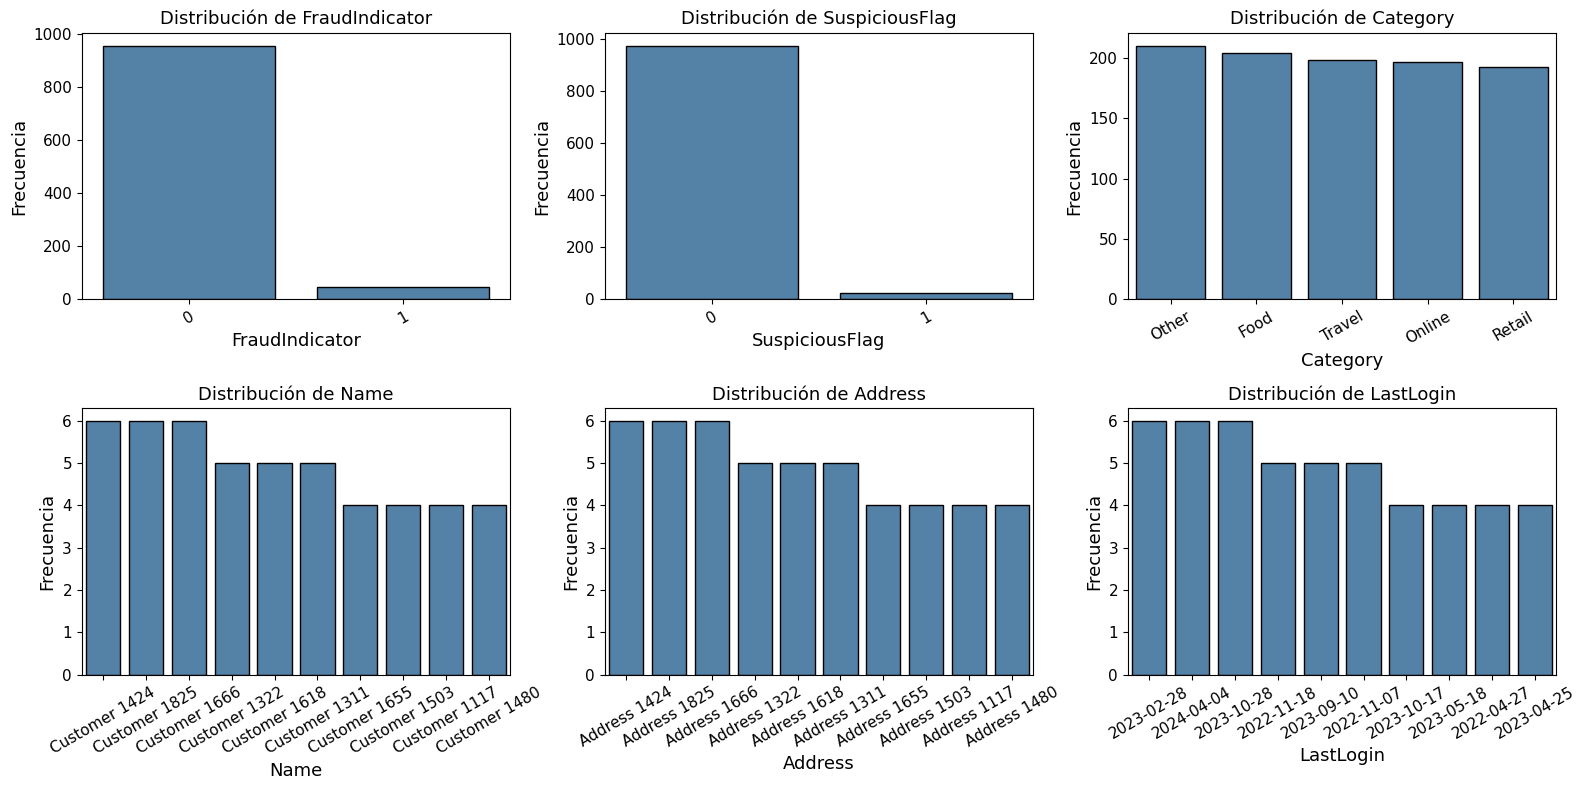

In [ ]:
# Definir número de columnas y calcular filas necesarias
ncols = 3
nrows = (len(categorical_columns) + ncols - 1) // ncols

# Crear figura y ejes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

# Graficar cada variable
for idx, column in enumerate(categorical_columns):
    top_10_values = data[column].value_counts().head(10)
    sns.countplot(
        x=column,
        data=data,
        order=top_10_values.index,
        color="steelblue",
        edgecolor='black',
        ax=axes[idx]
    )
    axes[idx].set_title(f'Distribución de {column}', fontsize=13)
    axes[idx].set_xlabel(column, fontsize=13)
    axes[idx].set_ylabel('Frecuencia', fontsize=13)
    axes[idx].tick_params(axis='x', rotation=30, labelsize=11)
    axes[idx].tick_params(axis='y', labelsize=11)

# Eliminar subplots vacíos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Histplot para variables numéricas

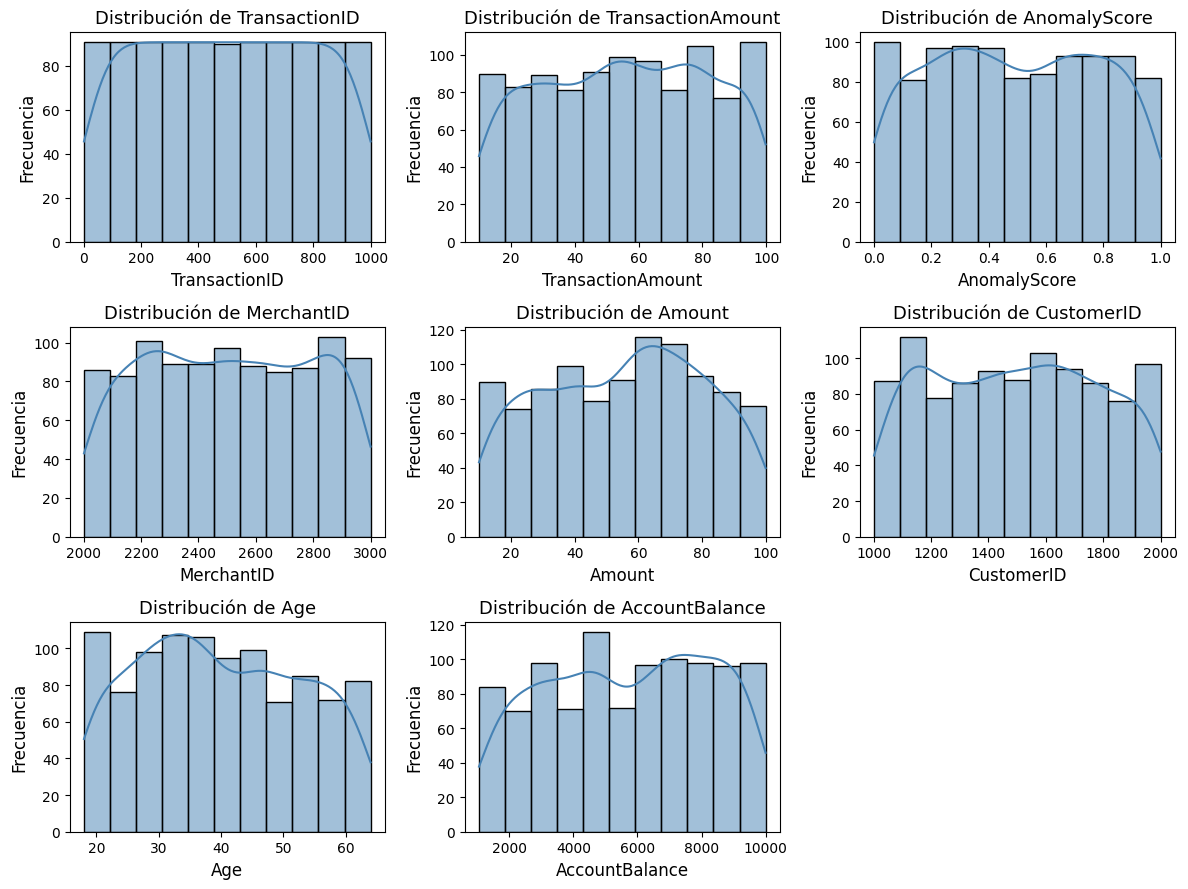

In [ ]:
# Crear figura y subplots
fig, axes = plt.subplots(
    nrows=(len(numeric_columns) + 2) // 3,  # Ajuste pequeño para 3 columnas
    ncols=3,
    figsize=(12, 9)
)

# Aplanar el array de ejes
axes = axes.flatten()

# Recorrer variables numéricas
for idx, column in enumerate(numeric_columns):
    sns.histplot(
        data[column], 
        kde=True, 
        color="steelblue",
        ax=axes[idx]  
    )
    axes[idx].set_title(f'Distribución de {column}', fontsize=13)
    axes[idx].set_xlabel(column, fontsize=12)
    axes[idx].set_ylabel('Frecuencia', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=0)

# Eliminar subplots vacíos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espacio
plt.tight_layout()
plt.show()


## BoxPlot de variables numericas

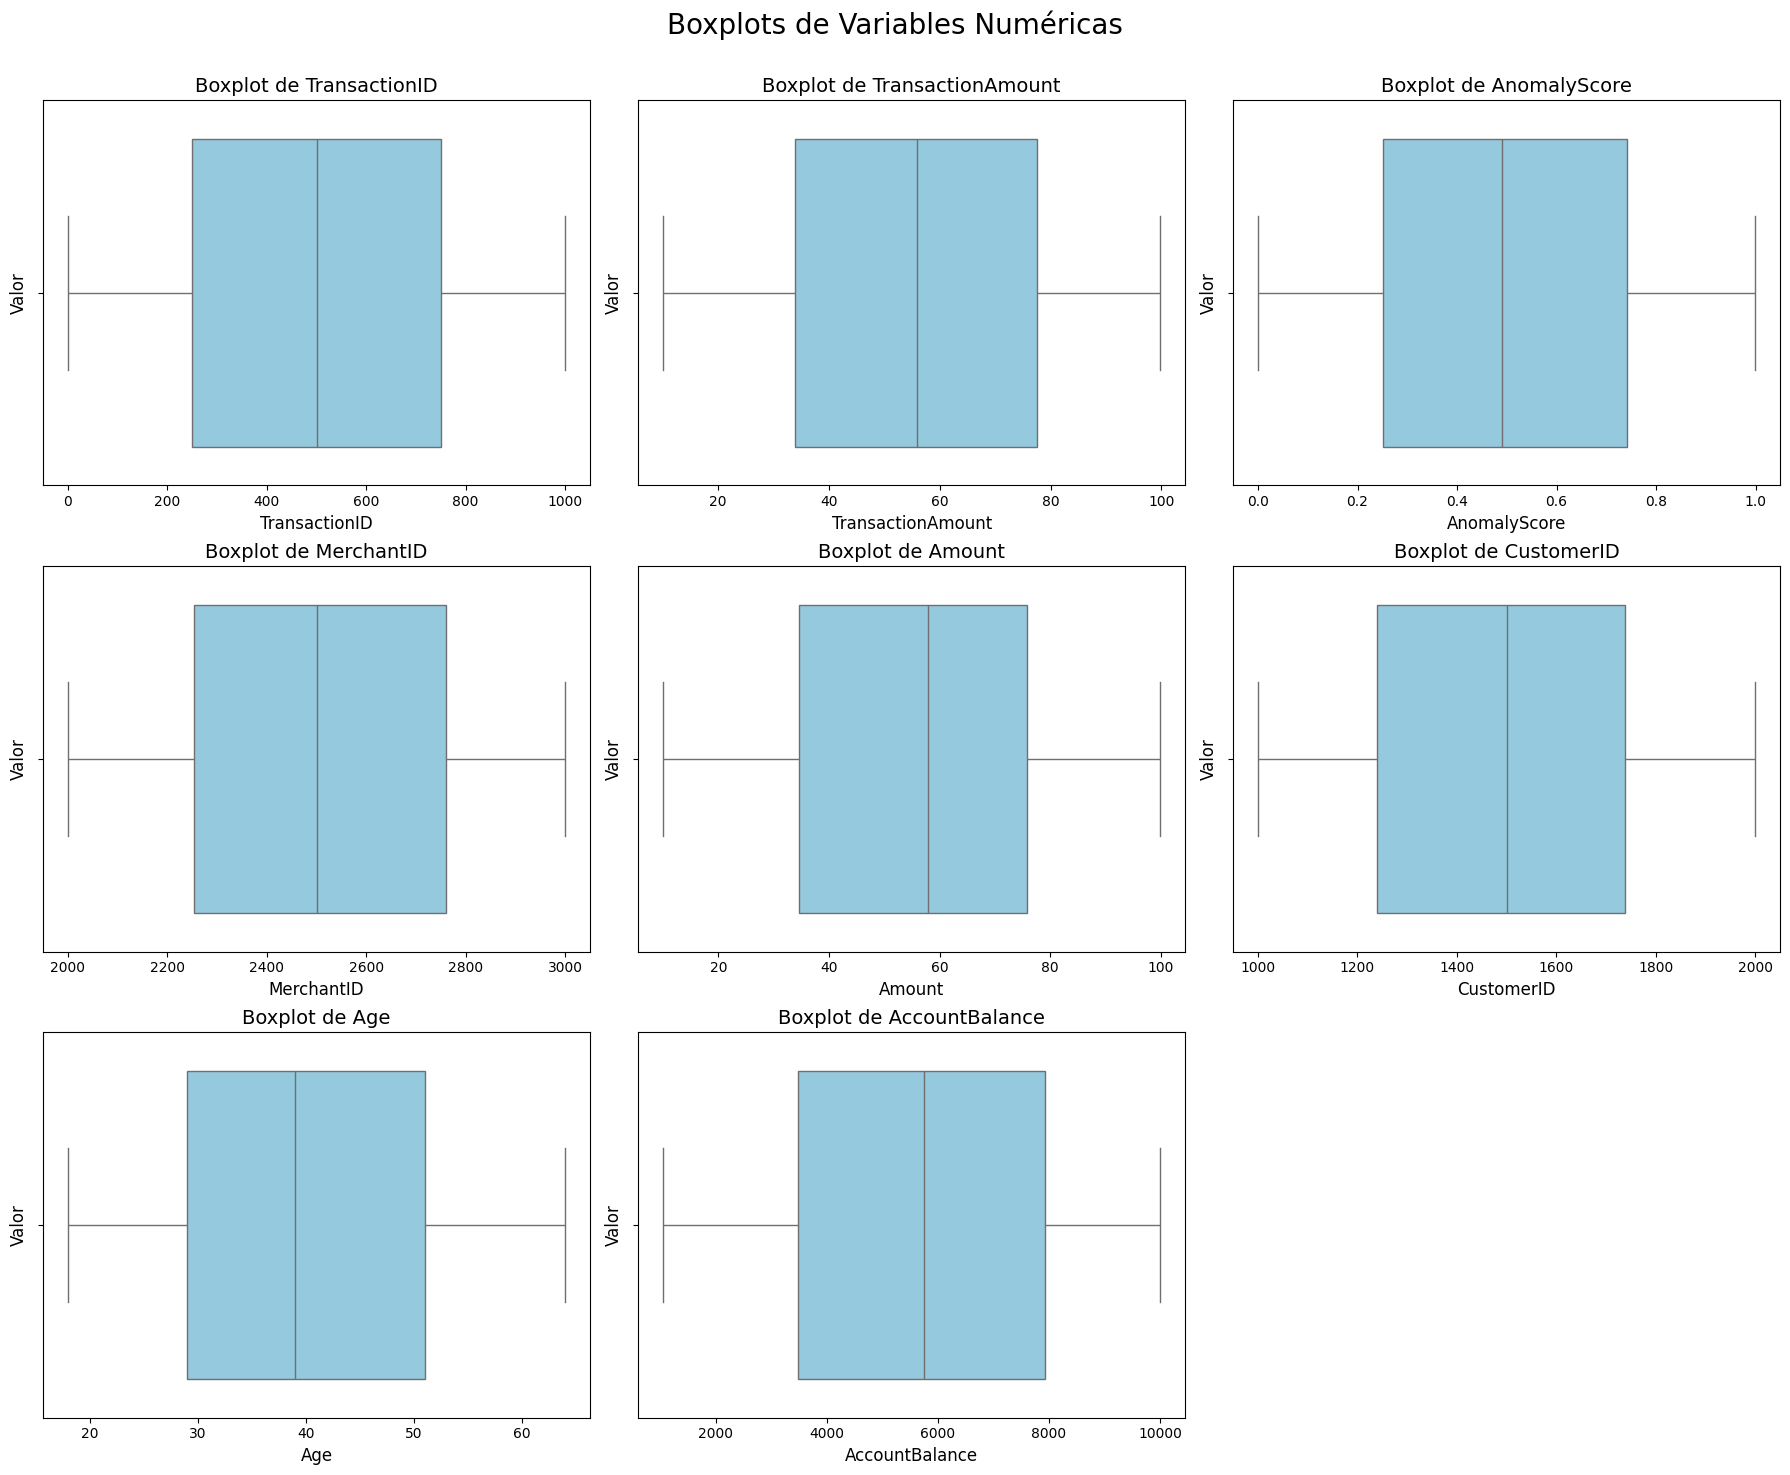

In [ ]:
num_cols = len(numeric_columns)

# Definir cantidad de filas y columnas
ncols = 3  # Dos boxplots por fila
nrows = (num_cols + ncols - 1) // ncols  # Redondeo para arriba

# Crear figura y subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()  # Aplanar para fácil iteración

# Dibujar los boxplots
for idx, column in enumerate(numeric_columns):
    sns.boxplot(
        x=data[column],
        color='skyblue',
        ax=axes[idx]
    )
    axes[idx].set_title(f'Boxplot de {column}', fontsize=14)
    axes[idx].set_xlabel(column, fontsize=12)
    axes[idx].set_ylabel('Valor', fontsize=12)

# Si sobran ejes vacíos, eliminarlos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Boxplots de Variables Numéricas', fontsize=20)
plt.show()


## Matriz de correlación a variables numericas

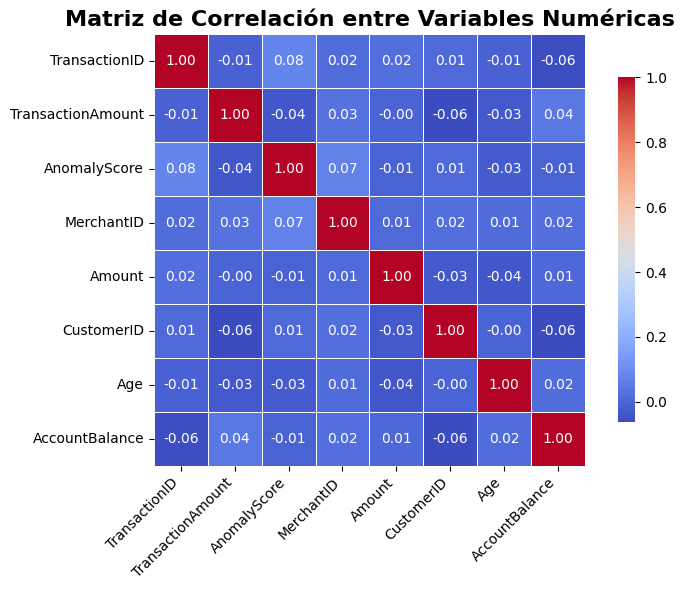

In [ ]:
# Filtrar solo las columnas numéricas
numeric_df = data[numeric_columns]

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,            # Mostrar los números
    cmap='coolwarm',        # Mantener la misma paleta
    fmt=".2f",              # Formato de los números
    linewidths=0.5,         # Separación entre cuadros
    linecolor='white',      # Color de las líneas
    square=True,            # Que cada celda sea cuadrada
    cbar_kws={"shrink": .8} # Hacer la barra de colores más pequeña
)
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para que no se superpongan
plt.yticks(rotation=0)               # Mantener las etiquetas de Y horizontales
plt.tight_layout()
plt.show()


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Feature Engineering</h1>
</div>


<b> Feature Engineering consiste en seleccionar y transformar las variables que se utilizarán en el modelo. Tambien normalizar variables, manipular datos categóricos y crear nuevas variables a partir de las existentes </b> 

<b> Se analiza el poder predictivo de CustomerID y MerchantID </b> 
- fraude_rate_cliente vs FraudIndicator
Para las transacciones no fraudulentas (0), la tasa de fraude promedio por cliente es cercana a 0.
Para las transacciones fraudulentas (1), hay una distribución más amplia de tasas de fraude por cliente, con valores medianos y altos, lo que indica que ciertos clientes tienen un historial más asociado al fraude.
Esto sugiere que la variable relacionada al cliente sí tiene poder predictivo: los clientes con tasas más altas están más asociados a fraude.

- fraude_rate_comercio vs FraudIndicator
Para transacciones no fraudulentas, la tasa por comercio es baja o cero.
En las fraudulentas, hay mayor variación y valores altos.
El comercio también parece tener relación con el fraude. Algunos comercios tienen alta tasa de fraude y aparecen en transacciones fraudulentas.

<b> Conclusión</b> : tanto CustomerID como MerchantID parecen contener información relevante.

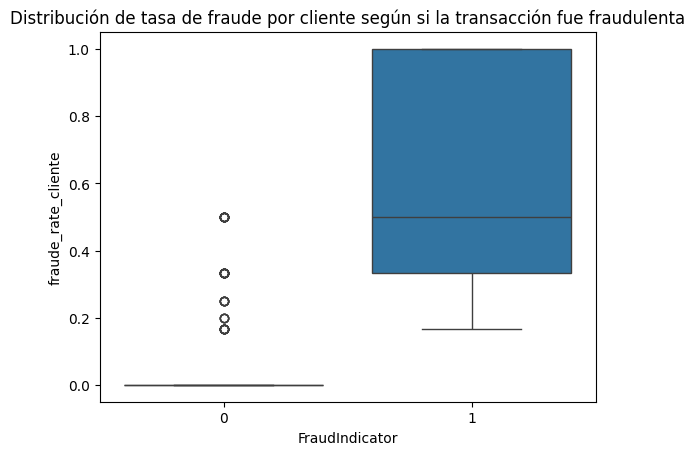

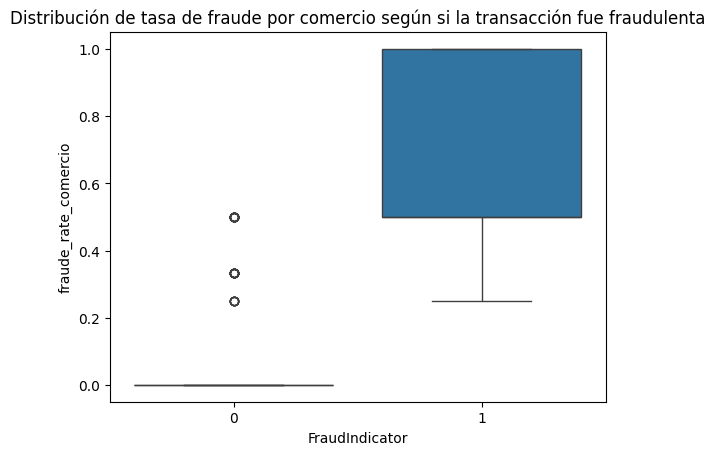

In [ ]:
data2 = data.copy()

# Fraude medio por CustomerID
fraude_por_cliente = data2.groupby('CustomerID')['FraudIndicator'].mean().reset_index()
fraude_por_cliente.columns = ['CustomerID', 'fraude_rate_cliente']

# Fraude medio por MerchantID
fraude_por_comercio = data2.groupby('MerchantID')['FraudIndicator'].mean().reset_index()
fraude_por_comercio.columns = ['MerchantID', 'fraude_rate_comercio']

# Analisis de la distribución
data2 = data2.merge(fraude_por_cliente, on='CustomerID', how='left')
data2 = data2.merge(fraude_por_comercio, on='MerchantID', how='left')

sns.boxplot(x='FraudIndicator', y='fraude_rate_cliente', data=data2)
plt.title('Distribución de tasa de fraude por cliente según si la transacción fue fraudulenta')
plt.show()

sns.boxplot(x='FraudIndicator', y='fraude_rate_comercio', data=data2)
plt.title('Distribución de tasa de fraude por comercio según si la transacción fue fraudulenta')
plt.show()



In [ ]:
# Eliminar las columnas a partir de ahora no están muy correlacionadas y tampoco afectaría el rendimiento del modelo.
columns_to_be_dropped = ['TransactionID','Name', 'Age', 'Address']
data1 = data.drop(columns_to_be_dropped, axis=1)
data1.head()

,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,AccountBalance,LastLogin,SuspiciousFlag
0,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,2869.689912,2024-08-09,0
1,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,9527.947107,2022-01-27,0
2,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,9288.355525,2024-08-12,0
3,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,5588.049942,2024-03-06,0
4,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,7324.785332,2024-08-03,0


In [ ]:
data1['FraudIndicator'].value_counts(), data1['SuspiciousFlag'].value_counts(), data1['Category'].value_counts()

(FraudIndicator
 0    955
 1     45
 Name: count, dtype: int64,
 SuspiciousFlag
 0    975
 1     25
 Name: count, dtype: int64,
 Category
 Other     210
 Food      204
 Travel    198
 Online    196
 Retail    192
 Name: count, dtype: int64)

In [ ]:
# Using Feature Engineering Creating two Columns
# Hour of Transaction = hour
# Gap between the day of transaction and last login in days = gap

data1['Hour'] = data1['Timestamp'].dt.hour
data1['gap'] = (data1['Timestamp'] - data1['LastLogin']).dt.days.abs()
data1['DayOfWeek'] = data1['Timestamp'].dt.dayofweek

# Mes del año (1=enero, 12=diciembre)
data1['Month'] = data1['Timestamp'].dt.month

# Proporción del monto sobre el saldo
data1['TransactionAmountRelativeToBalance'] = data1['TransactionAmount'] / data1['AccountBalance']

# (opcional) Si querés eliminar infinitos por divisiones por cero
data1['TransactionAmountRelativeToBalance'].replace([np.inf, -np.inf], np.nan, inplace=True)
data1['TransactionAmountRelativeToBalance'].fillna(0, inplace=True)

data1['BalancePostTransaction'] = data1['AccountBalance'] - data1['TransactionAmount']
data1['IsWeekend'] = data1['DayOfWeek'].isin([5, 6]).astype(int)


data1.head()

,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,AccountBalance,LastLogin,SuspiciousFlag,Hour,gap,DayOfWeek,Month,TransactionAmountRelativeToBalance,BalancePostTransaction,IsWeekend
0,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,2869.689912,2024-08-09,0,0,951,5,1,0.027673,2790.276305,1
1,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,9527.947107,2022-01-27,0,1,26,5,1,0.001265,9515.894020,1
2,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,9288.355525,2024-08-12,0,2,954,5,1,0.003586,9255.045168,1
3,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,5588.049942,2024-03-06,0,3,795,5,1,0.008254,5541.928824,1
4,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,7324.785332,2024-08-03,0,4,945,5,1,0.007379,7270.733714,1


In [ ]:
# Se eliminan las columnas que no son relevantes y se separa la variable objetivo en la variable Y
x_data = data1.drop(['FraudIndicator','Timestamp','LastLogin'],axis=1)
y_data = data1['FraudIndicator']

In [ ]:
# Utiliza LabelEncoder para transformar valores categóricos (como texto) en números
label_encoder = LabelEncoder()
x_data['Category'] = label_encoder.fit_transform(x_data['Category'])
x_data

,Category,TransactionAmount,AnomalyScore,MerchantID,Amount,CustomerID,AccountBalance,SuspiciousFlag,Hour,gap,DayOfWeek,Month,TransactionAmountRelativeToBalance,BalancePostTransaction,IsWeekend
0,2,79.413607,0.686699,2701,55.530334,1952,2869.689912,0,0,951,5,1,0.027673,2790.276305,1
1,1,12.053087,0.081749,2070,12.881180,1027,9527.947107,0,1,26,5,1,0.001265,9515.894020,1
2,4,33.310357,0.023857,2238,50.176322,1955,9288.355525,0,2,954,5,1,0.003586,9255.045168,1
3,4,46.121117,0.876994,2879,41.634001,1796,5588.049942,0,3,795,5,1,0.008254,5541.928824,1
4,2,54.051618,0.034059,2966,78.122853,1946,7324.785332,0,4,945,5,1,0.007379,7270.733714,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,89.457059,0.266778,2150,19.876750,1411,1290.323059,0,11,369,4,2,0.069329,1200.866000,0
996,3,47.958030,0.512483,2888,96.299792,1566,7067.831609,0,12,524,4,2,0.006785,7019.873579,0
997,0,64.210046,0.367740,2037,75.164459,1654,9088.738359,0,13,612,4,2,0.007065,9024.528313,0
998,4,64.684167,0.960364,2629,93.633040,1928,9352.655675,0,14,886,4,2,0.006916,9287.971508,0


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Normalización de datos</h1>
</div>

In [ ]:
def normalizar_datos(x):
    # Columnas a escalar
    cols_to_scale = ['TransactionAmount', 'Amount', 'AccountBalance', 'gap']

    # Inicializar el scaler
    scaler = StandardScaler()

    # Ajustar el scaler y transformar los datos
    x[cols_to_scale] = scaler.fit_transform(x[cols_to_scale])

    return x

<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Sobremuestreo de datos</h1>
</div>

In [ ]:
def sobremuestreo_de_datos(x, y):
    # Initialize SMOTE for oversampling
    smote = SMOTE(random_state=42)

    # Apply SMOTE to the data
    x_resampled, y_resampled = smote.fit_resample(x, y)

    return x_resampled, y_resampled


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Modelado de datos</h1>
</div>


Configuracion MLFlow

In [ ]:
if CARGA_MFLOW:
    mlflow.set_tracking_uri("http://localhost:8080")
    mlflow.set_experiment("Detección de fraude electrónico")

### Regresión logística

#### Definicion de configuraciones y parametros

In [ ]:
# Pipeline con normalización y SMOTE
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=500))  # Parámetros default, se sobreescriben en GridSearch
])


scoring_lr = {
    'acc': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score)
}

skf_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_grid_lr = [
    # Solvers que soportan l2
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 1.0, 10],
        'clf__solver': ['lbfgs', 'sag', 'newton-cg', 'saga', 'liblinear'],
        'clf__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}, {0: 1, 1: 5}, {0: 1, 1: 10}], # Añadidas opciones de diccionario
        'clf__max_iter': [100, 500, 1000],
        'clf__fit_intercept': [True, False],
        'clf__tol': [0.0001, 0.001]
    },
    
    # l1 solo compatible con saga y liblinear
    {
        'clf__penalty': ['l1'],
        'clf__C': [0.01, 0.1, 1.0, 10],
        'clf__solver': ['liblinear', 'saga'],
        'clf__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}, {0: 1, 1: 5}, {0: 1, 1: 10}], # Añadidas opciones de diccionario
        'clf__max_iter': [100, 500, 1000],
        'clf__fit_intercept': [True, False],
        'clf__tol': [0.0001, 0.001]
    },

    # elasticnet solo con saga
    {
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.01, 0.1, 1.0, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.25, 0.5, 0.75, 0.9],
        'clf__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}, {0: 1, 1: 5}, {0: 1, 1: 10}], # Añadidas opciones de diccionario
        'clf__max_iter': [100, 500, 1000],
        'clf__fit_intercept': [True, False],
        'clf__tol': [0.0001, 0.001]
    }
]

#### Entraneminto y evaluación

In [ ]:
grid_search_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    scoring=scoring_lr,
    refit='auc',  
    cv=skf_lr,
    verbose=2,
    n_jobs=-1
)

grid_result_lr = grid_search_lr.fit(x_data, y_data)

print("Mejor modelo:", grid_result_lr.best_estimator_)
print("Mejores parámetros:", grid_result_lr.best_params_)
print("Mejor AUC:", grid_result_lr.best_score_)

# Exportar resultados
results_df = pd.DataFrame(grid_result_lr.cv_results_)
results_df.to_csv("resultados/logistic_gridsearch_results.csv", index=False, sep='|', decimal=',')


Fitting 5 folds for each of 2640 candidates, totalling 13200 fits
Mejor modelo: Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    solver='liblinear'))])
Mejores parámetros: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__fit_intercept': True, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'clf__tol': 0.0001}
Mejor AUC: 0.541826643397324


#### Ajuste del Umbral de Clasificación


--- Threshold: 0.5 ---
Matriz de confusión:
 [[546 409]
 [ 14  31]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9750    0.5717    0.7208       955
           1     0.0705    0.6889    0.1278        45

    accuracy                         0.5770      1000
   macro avg     0.5227    0.6303    0.4243      1000
weighted avg     0.9343    0.5770    0.6941      1000

AUC: 0.652216404886562


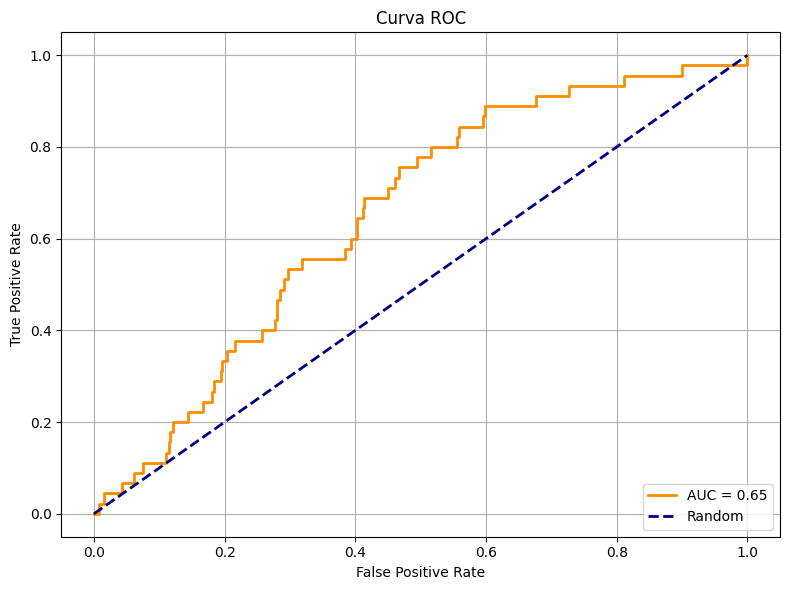

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener el mejor pipeline entrenado
best_pipeline = grid_result_lr.best_estimator_

y_proba = best_pipeline.predict_proba(x_data)[:, 1]  # Probabilidad de clase 1

#for t in [0.8, 0.75, 0.72, 0.7, 0.65, 0.6, 0.5]:
for t in [0.5]:
    print(f"\n--- Threshold: {t} ---")
    y_pred = (y_proba >= t).astype(int)
    
    print("Matriz de confusión:\n", confusion_matrix(y_data, y_pred))
    print("\nReporte de clasificación:\n", classification_report(y_data, y_pred, digits=4))
    print("AUC:", roc_auc_score(y_data, y_proba))


# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_data, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show() 


#### Validacion de importancia de variables

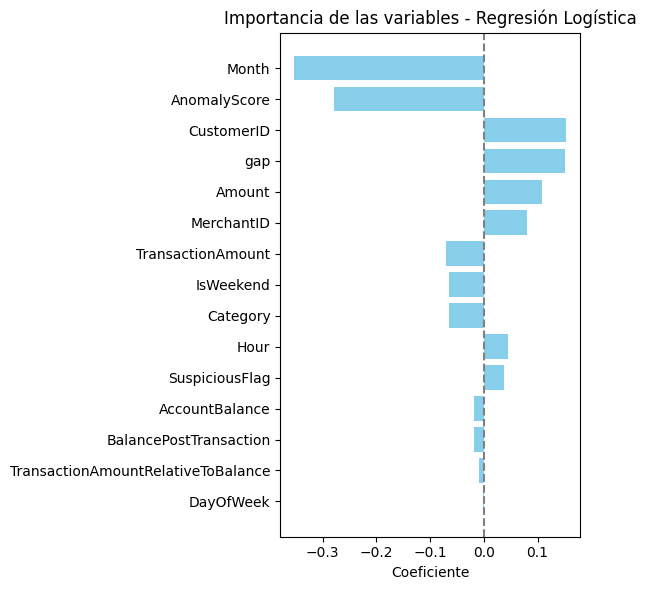

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_pipeline = grid_search_lr.best_estimator_

# Obtener los coeficientes del modelo (es un array 2D, tomamos la fila 0)
coefs = best_pipeline.named_steps['clf'].coef_[0]
features = best_pipeline.named_steps['scaler'].get_feature_names_out(x_data.columns)

# Ordenarlos por magnitud absoluta
sorted_idx = np.argsort(np.abs(coefs))

plt.figure(figsize=(6, 6))
plt.barh(range(len(features)), coefs[sorted_idx], color='skyblue')
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Coeficiente")
plt.title("Importancia de las variables - Regresión Logística")
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

#### Guardado en MLFlow de mejor modelo

In [ ]:
from sklearn.model_selection import cross_validate

# Configuración final de los hiperparámetros de Regresión Logística
final_lr_params = {
    'clf__penalty': 'l2',
    'clf__C': 0.01,
    'clf__solver': 'liblinear',
    'clf__class_weight': 'balanced', # Asumiendo 'balanced' como el valor del diccionario que funciona mejor
    'clf__max_iter': 100,
    'clf__fit_intercept': True,
    'clf__tol': 0.0001
}

# Aplicar los parámetros directamente al pipeline
pipeline_lr.set_params(**final_lr_params)

cv_results_final_model = cross_validate(
    pipeline_lr,
    x_data,
    y_data,
    scoring=scoring_lr,
    cv=skf_lr,
    return_train_score=False, # No necesitas las puntuaciones de entrenamiento aquí
    n_jobs=-1
)

# Calcula las medias de las métricas de validación
mean_metrics_final = {
    score_name: np.mean(cv_results_final_model[f'test_{score_name}'])
    for score_name in scoring_lr.keys()
}

# Entrenar el modelo final en todo el conjunto de datos para poder guardarlo y usarlo para predicciones
final_model = pipeline_lr.fit(x_data, y_data)

# --- Registro en MLflow ---
if CARGA_MFLOW:
    with mlflow.start_run(run_name="Logistic_Regression_Final_Model_run"):
        # 1. Registrar los hiperparámetros del modelo final
        mlflow.log_params(final_lr_params)

        # 2. Registrar las métricas del modelo final (promedio de CV)
        mlflow.log_metrics(mean_metrics_final)

        # 3. Calcular y graficar la Curva ROC para el modelo final entrenado
        y_pred_proba = final_model.predict_proba(x_data)[:, 1]  # Probabilidad de la clase positiva

        fpr, tpr, thresholds = roc_curve(y_data, y_pred_proba)
        best_auc = roc_auc_score(y_data, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC del Modelo Final (AUC = {best_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Línea Aleatoria')
        plt.xlabel("Tasa de Falsos Positivos (FPR)")
        plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
        plt.title("Curva ROC del Modelo Final de Regresión Logística")
        plt.legend(fontsize="medium")
        plt.grid(True)
        plt.tight_layout()

        # Si quieres guardar la figura en un archivo y loggearla en MLflow
        plt.savefig("./services/mlflow/figures/roc_curve_final_model.png")
        mlflow.log_artifact("./services/mlflow/figures/roc_curve_final_model.png")
        plt.close()

        # 4. Crea un ejemplo de entrada utilizando tus datos (x_data)
        input_example_for_mlflow = x_data.sample(n=5, random_state=42) if isinstance(x_data, pd.DataFrame) else x_data[:5]

        # 5. Inferir la firma del modelo
        signature = infer_signature(input_example_for_mlflow, final_model.predict(input_example_for_mlflow))

        # 6. Guardar el modelo final
        mlflow.sklearn.log_model(
            sk_model=final_model,
            artifact_path="models",
            registered_model_name="LogisticRegression_Model",
            signature=signature,
            input_example=input_example_for_mlflow
        )

        print("\n--- MLflow ---")
        print(f"Modelo y métricas registrados en MLflow con Run ID: {mlflow.active_run().info.run_id}")
        print(f"Para ver los resultados, ejecuta 'mlflow ui' en tu terminal.")

### XGBoost

#### Definición de configuraciones y parametros

In [ ]:
scoring_xgb = {
    'acc': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score)
}

pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb_clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss')) 
 ])

skf_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_grid_xgb = {
    'xgb_clf__n_estimators': [50, 100, 200],
    'xgb_clf__learning_rate': [0.005,0.01, 0.05],
    'xgb_clf__max_depth': [3, 4, 5, 6],
    'xgb_clf__subsample': [0.5, 0.7, 1.0],
    'xgb_clf__colsample_bytree': [0.5, 0.7, 1.0],
    'xgb_clf__gamma': [0, 0.05, 0.1],
    'xgb_clf__reg_alpha': [0, 0.005, 0.01],
    'xgb_clf__reg_lambda': [0.1, 0.5, 1],
    'xgb_clf__scale_pos_weight': [1, 3, 5, 10, 12]
}
param_grid_xgb_2 = {
    'xgb_clf__n_estimators': [200, 250,300],
    'xgb_clf__learning_rate': [0.005,0.01],
    'xgb_clf__max_depth': [4, 5],
    'xgb_clf__subsample': [0.7],
    'xgb_clf__colsample_bytree': [1.0],
    'xgb_clf__gamma': [0, 0.05, 0.1],
    'xgb_clf__reg_alpha': [0, 0.005, 0.01],
    'xgb_clf__reg_lambda': [0.5, 1],
    'xgb_clf__scale_pos_weight': [9, 10]
}
param_grid_xgb_3 = {
    'xgb_clf__n_estimators': [100, 200],
    'xgb_clf__learning_rate': [0.005, 0.01],
    'xgb_clf__max_depth': [4, 5],
    'xgb_clf__subsample': [0.7],
    'xgb_clf__colsample_bytree': [1.0],
    'xgb_clf__gamma': [0],
    'xgb_clf__reg_alpha': [0],
    'xgb_clf__reg_lambda': [1],
    'xgb_clf__scale_pos_weight': [9, 10]
}


In [ ]:
param_grid_xgb_final = {
    'xgb_clf__n_estimators': [200],
    'xgb_clf__learning_rate': [0.005],
    'xgb_clf__max_depth': [5],
    'xgb_clf__subsample': [0.7],
    'xgb_clf__colsample_bytree': [1.0],
    'xgb_clf__gamma': [0],
    'xgb_clf__reg_alpha': [0],
    'xgb_clf__reg_lambda': [1],
    'xgb_clf__scale_pos_weight': [9, 10]
}

#### Entrenamiento y evaluación

In [ ]:
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, 
                            param_grid=param_grid_xgb_final,
                            scoring=scoring_xgb, 
                            refit='auc', 
                            cv= skf_xgb,
                            n_jobs=-1, # Usa todos los núcleos disponibles
                            verbose=2) # Para ver el progreso

# Asumiendo que X_train e y_train son tus datos de entrenamiento
grid_search_xgb.fit(x_data, y_data)

print("Mejores parámetros encontrados:", grid_search_xgb.best_params_)
print("Mejor puntuación:", grid_search_xgb.best_score_)

# Exportar resultados
results_df = pd.DataFrame(grid_search_xgb.cv_results_)
results_df.to_csv("resultados/xgboost_gridsearch_results.csv", index=False, sep='|', decimal=',')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores parámetros encontrados: {'xgb_clf__colsample_bytree': 1.0, 'xgb_clf__gamma': 0, 'xgb_clf__learning_rate': 0.005, 'xgb_clf__max_depth': 5, 'xgb_clf__n_estimators': 200, 'xgb_clf__reg_alpha': 0, 'xgb_clf__reg_lambda': 1, 'xgb_clf__scale_pos_weight': 9, 'xgb_clf__subsample': 0.7}
Mejor puntuación: 0.5999999999999999


#### Validacion de importancia de variables

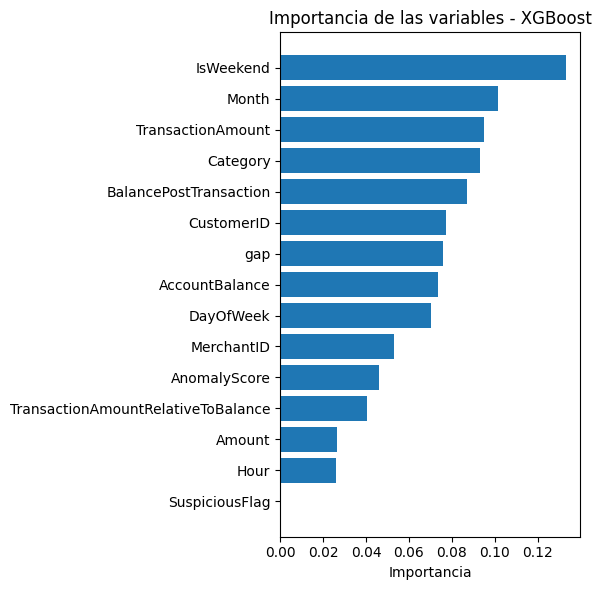

In [ ]:
import matplotlib.pyplot as plt
best_pipeline = grid_search_xgb.best_estimator_

importances = best_pipeline.named_steps['xgb_clf'].feature_importances_
features = x_data.columns  # O las columnas después del preprocesamiento
sorted_idx = importances.argsort()

plt.figure(figsize=(6,6))
plt.barh(range(len(features)), importances[sorted_idx])
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Importancia")
plt.title("Importancia de las variables - XGBoost")
plt.tight_layout()
plt.show()


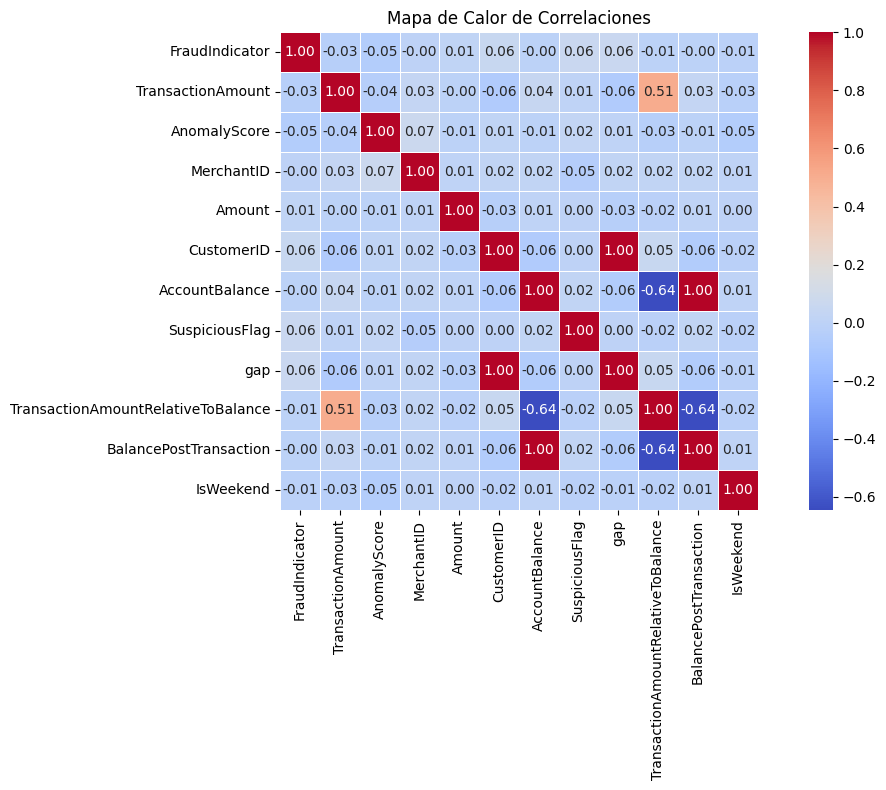

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurate de trabajar solo con columnas numéricas
numeric_data = data1.select_dtypes(include=['float64', 'int64'])

# Calcula la matriz de correlación
correlation_matrix = numeric_data.corr()

# Crea el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones")
plt.tight_layout()
plt.show()


#### Ajuste del Umbral de Clasificación


--- Threshold: 0.7 ---
Matriz de confusión:
 [[640 315]
 [  2  43]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9969    0.6702    0.8015       955
           1     0.1201    0.9556    0.2134        45

    accuracy                         0.6830      1000
   macro avg     0.5585    0.8129    0.5075      1000
weighted avg     0.9574    0.6830    0.7750      1000

AUC: 0.8271902268760908
Curva ROC:
 [[640 315]
 [  2  43]]


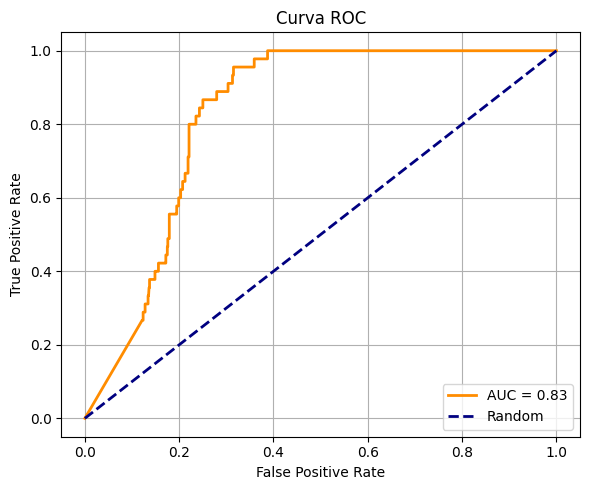

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener el mejor pipeline entrenado
best_pipeline = grid_search_xgb.best_estimator_

y_proba = best_pipeline.predict_proba(x_data)[:, 1]  # Probabilidad de clase 1

print(f"\n--- Threshold: {0.7} ---")
y_pred = (y_proba >= 0.7).astype(int)

print("Matriz de confusión:\n", confusion_matrix(y_data, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_data, y_pred, digits=4))
print("AUC:", roc_auc_score(y_data, y_proba))


# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_data, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
print("Curva ROC:\n", confusion_matrix(y_data, y_pred))
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

#### Guardado en MLFlow del mejor modelo 

In [ ]:
if CARGA_MFLOW:
    with mlflow.start_run(run_name="XGBoost_Best_Model_GridSearch"):
        # 1. Registrar los hiperparámetros del mejor modelo
        mlflow.log_params(grid_search_xgb.best_params_)
        mlflow.log_param("threshold", 0.7)


        # 2. Registrar las métricas del mejor modelo
        best_index = grid_search_xgb.best_index_
        metrics_to_log = {}
        for score_name in scoring_xgb.keys():
            metric_col = f'mean_test_{score_name}'
            metrics_to_log[score_name] = grid_search_xgb.cv_results_[metric_col][best_index]
        
        mlflow.log_metrics(metrics_to_log)

        # 3. Guardar curva ROC para el mejor modelo
        mlflow.log_artifact("./services/mlflow/figures/roc_curve_xgboost.png")

        # 3. Crea un ejemplo de entrada utilizando tus datos (x_data)
        input_example_for_mlflow = x_data.sample(n=5, random_state=42) if isinstance(x_data, pd.DataFrame) else x_data[:5]

        # 4. Inferir la firma del modelo
        signature = infer_signature(input_example_for_mlflow, grid_search_xgb.best_estimator_.predict(input_example_for_mlflow))

        # 5. Guardar el mejor modelo
        mlflow.sklearn.log_model(
            sk_model=grid_search_xgb.best_estimator_,
            artifact_path="model", 
            registered_model_name="XGBoostModel",
            signature=signature,
            input_example=input_example_for_mlflow
        )

        print("\n--- MLflow ---")
        print(f"Modelo y métricas registrados en MLflow con Run ID: {mlflow.active_run().info.run_id}")
        print(f"Para ver los resultados, ejecuta 'mlflow ui' en tu terminal.")

## Red Neuronal

Se define la clase MyKerasClassifier para reemplazar a KerasClassifier,
debido a que en versiones recientes de scikit-learn (≥0.24) y TensorFlow (≥2.6),
este último presenta problemas de compatibilidad: no implementa correctamente
el método score() y sus predicciones pueden no ser compatibles con métricas
como F1, precisión y recall. Esto impide que GridSearchCV calcule correctamente
los resultados cuando se utilizan múltiples métricas. Al definir un estimador
personalizado compatible con la API de scikit-learn, se garantiza el funcionamiento
correcto dentro del pipeline y del proceso de validación cruzada.

In [ ]:
class MyKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layers=[(64, 'relu')], dropout_rate=0.0, optimizer='adam',
                 output_activation='sigmoid', epochs=10, batch_size=32, verbose=0):
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.output_activation = output_activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None

    def build_model(self, input_dim):
        model = Sequential()

        # Agregamos la capa de entrada una sola vez
        model.add(Input(shape=(input_dim,)))

        # Capas ocultas
        for units, activation in self.hidden_layers:
            if activation == 'leaky_relu':
                model.add(Dense(units))
                model.add(LeakyReLU(alpha=0.01))
            else:
                model.add(Dense(units, activation=activation))
            model.add(Dropout(self.dropout_rate))

        # Capa de salida
        model.add(Dense(1, activation=self.output_activation))

        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model_ = self.build_model(X.shape[1])
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        preds = self.model_.predict(X)
        return (preds > 0.5).astype(int).ravel()

    def predict_proba(self, X):
        preds = self.model_.predict(X)
        return np.hstack([(1 - preds), preds])

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

NameError: name 'BaseEstimator' is not defined

#### Definición de configuraciones y parametros

In [ ]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='binary'),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'auc': make_scorer(roc_auc_score)
}

model = MyKerasClassifier()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', model)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
param_grid_1 = {
    'clf__batch_size': [32],
    'clf__epochs': [50, 100, 150],  
    'clf__dropout_rate': [0.0],
    'clf__optimizer': ['adam'],
    'clf__hidden_layers': [
        [(64, 'relu')],
        [(64, 'tanh')],
        [(64, 'leaky_relu')],
        [(64, 'elu')],
        [(64, 'prelu')], 
        [(64, 'selu')],
    ],
    'clf__output_activation': ['sigmoid']
}



param_grid = {
    'clf__batch_size': [32],
    'clf__epochs': [50],
    'clf__dropout_rate': [0.0],
    'clf__optimizer': ['adam'],
    'clf__hidden_layers': [
        [(64, 'relu')],  # una capa
        [(128, 'relu'), (64, 'relu')],  # dos capas
        [(128, 'relu'), (64, 'tanh'), (32, 'relu')]  
    ],
    'clf__output_activation': ['sigmoid']
}

### Entrenamiento y evaluación

In [ ]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_1,
    scoring=scoring,
    refit='auc',  
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Ejecutar búsqueda
grid_result = grid.fit(x_data, y_data)

# 📝 Guardar resultados
results_df = pd.DataFrame(grid_result.cv_results_)
results_df.to_csv("resultados/red_neuronal_grid_search.csv", index=False)

# 🏆 Mejor resultado
print("Mejor: %.4f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejor: 0.5858 usando {'clf__batch_size': 32, 'clf__dropout_rate': 0.0, 'clf__epochs': 50, 'clf__hidden_layers': [(64, 'tanh')], 'clf__optimizer': 'adam', 'clf__output_activation': 'sigmoid'}
